# Reconstructing the tropical Pacific SST with PAGES2k

In [1]:
%load_ext autoreload
%autoreload 2

import cfr
print(cfr.__version__)

2024.1.25


## Load the PAGES2k database

In [2]:
job = cfr.ReconJob()
job.load_proxydb('PAGES2kv2')

### Filter the database

We only need the corals in this example.

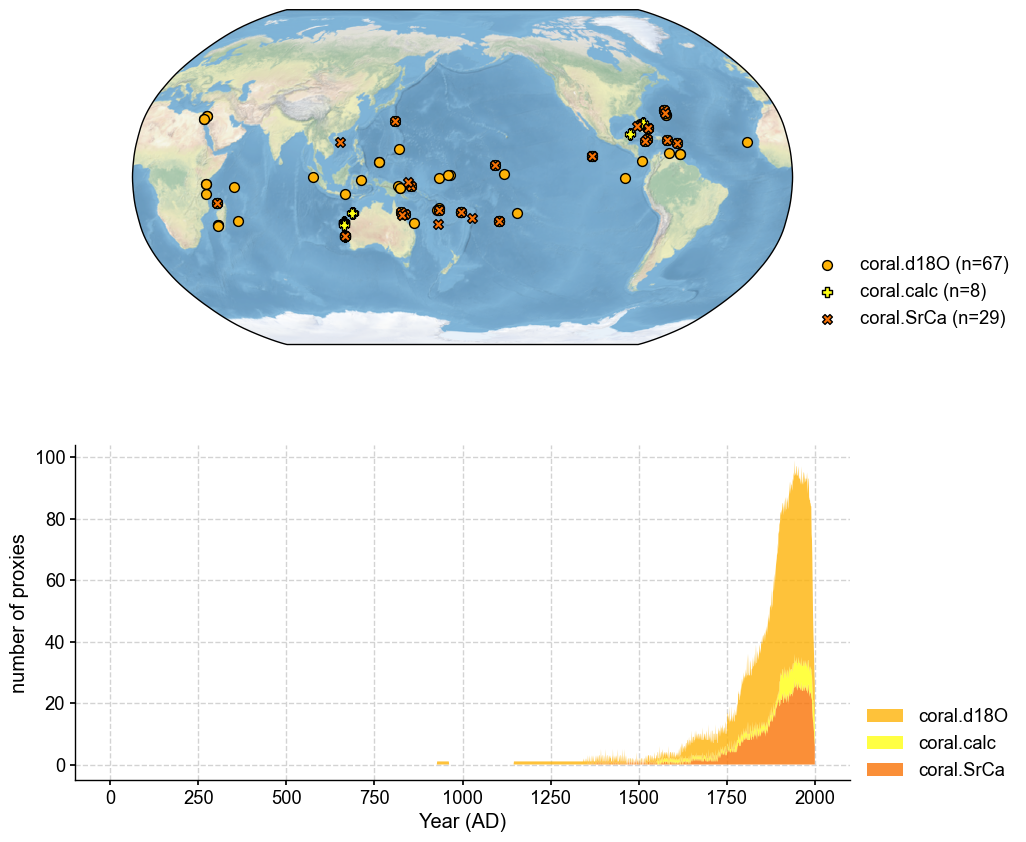

In [3]:
job.filter_proxydb(by='ptype', keys=['coral'])
fig, ax = job.proxydb.plot(plot_count=True)

### Annualize the database

In [4]:
job.annualize_proxydb(months=[12, 1, 2], ptypes=['coral'], verbose=True)

>>> job.configs["annualize_proxydb_months"] = [12, 1, 2]
>>> job.configs["annualize_proxydb_ptypes"] = ['coral']


Annualizing ProxyDatabase: 100%|██████████| 104/104 [00:01<00:00, 56.30it/s]

>>> 99 records remaining
>>> job.proxydb updated


## Load the gridded climate data

### Load the model prior

In [5]:
job.load_clim(
    tag='prior',
    path_dict={
        'tas': 'iCESM_past1000historical/tas',
    },
    anom_period=(1951, 1980),
)

>>> The target file seems existed at: ./data/tas_sfc_Amon_iCESM_past1000historical_085001-200512.nc . Loading from it instead of downloading ...


### Load the instrumental observations

In [6]:
job.load_clim(
    tag='obs',
    path_dict={
        'tas': 'gistemp1200_GHCNv4_ERSSTv5',
    },
    rename_dict={'tas': 'tempanomaly'},
    anom_period=(1951, 1980),
)

>>> The target file seems existed at: ./data/gistemp1200_GHCNv4_ERSSTv5.nc.gz . Loading from it instead of downloading ...


## Proxy system modeling

### Calibrating the proxy system models

In [7]:
ptype_psm_dict = {
    'coral.d18O': 'Linear',
    'coral.calc': 'Linear',
    'coral.SrCa': 'Linear',
}

ptype_season_dict = {
    'coral.d18O': [12, 1, 2],
    'coral.calc': [12, 1, 2],
    'coral.SrCa': [12, 1, 2],
}

ptype_clim_dict = {
    'coral.d18O': ['tas'],
    'coral.calc': ['tas'],
    'coral.SrCa': ['tas'],
}

job.calib_psms(
    ptype_psm_dict=ptype_psm_dict,
    ptype_season_dict=ptype_season_dict,
    ptype_clim_dict=ptype_clim_dict,
    calib_period=(1850, 2015),
    verbose=True,
)

>>> job.configs["ptype_psm_dict"] = {'coral.SrCa': 'Linear', 'coral.calc': 'Linear', 'coral.d18O': 'Linear'}
>>> job.configs["ptype_season_dict"] = {'coral.SrCa': [12, 1, 2], 'coral.calc': [12, 1, 2], 'coral.d18O': [12, 1, 2]}
>>> job.configs["psm_calib_period"] = (1850, 2015)


Calibrating the PSMs:   5%|▌         | 5/99 [00:00<00:02, 46.00it/s]

The number of overlapped data points is 14 < 25. Skipping ...


Calibrating the PSMs:  19%|█▉        | 19/99 [00:00<00:01, 61.99it/s]

The number of overlapped data points is 20 < 25. Skipping ...
The number of overlapped data points is 22 < 25. Skipping ...
The number of overlapped data points is 9 < 25. Skipping ...


Calibrating the PSMs:  32%|███▏      | 32/99 [00:00<00:01, 52.08it/s]

The number of overlapped data points is 24 < 25. Skipping ...


Calibrating the PSMs:  60%|█████▉    | 59/99 [00:01<00:00, 60.59it/s]

The number of overlapped data points is 22 < 25. Skipping ...
The number of overlapped data points is 22 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...


Calibrating the PSMs:  80%|███████▉  | 79/99 [00:01<00:00, 55.60it/s]

The number of overlapped data points is 21 < 25. Skipping ...


Calibrating the PSMs: 100%|██████████| 99/99 [00:01<00:00, 57.24it/s]

>>> PSM for Ocn_144 failed to be calibrated.
>>> PSM for Ocn_149 failed to be calibrated.
>>> PSM for Ocn_150 failed to be calibrated.
>>> PSM for Ocn_145 failed to be calibrated.
>>> PSM for Ocn_152 failed to be calibrated.
>>> PSM for Ocn_164 failed to be calibrated.
>>> PSM for Ocn_165 failed to be calibrated.
>>> PSM for Ocn_138 failed to be calibrated.
>>> PSM for Ocn_183 failed to be calibrated.
>>> 90 records tagged "calibrated" with ProxyRecord.psm created


### Forwarding the proxy system models

In [8]:
job.forward_psms()

Forwarding the PSMs: 100%|██████████| 90/90 [00:07<00:00, 12.77it/s]


## Annualizing, regridding, and cropping the prior field

In [9]:
job.annualize_clim(tag='prior', months=[12, 1, 2], verbose=True)
job.regrid_clim(tag='prior', nlat=42, nlon=63, verbose=True)
job.crop_clim(tag='prior', lat_min=-35, lat_max=35, verbose=True)

>>> job.configs["prior_annualize_months"] = [12, 1, 2]
>>> Processing tas ...
>>> job.prior updated
>>> job.configs["prior_regrid_nlat"] = 42
>>> job.configs["prior_regrid_nlon"] = 63
>>> Processing tas ...
>>> job.configs["prior_lat_min"] = -35
>>> job.configs["prior_lat_max"] = 35
>>> job.configs["prior_lon_min"] = 0
>>> job.configs["prior_lon_max"] = 360
>>> Processing tas ...


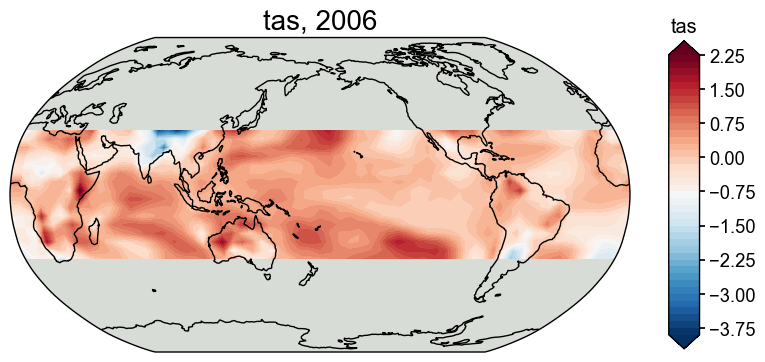

In [10]:
fig, ax = job.prior['tas'][-1].plot()

## Run the DA solver

In [11]:
job.run_da_mc(
    save_dirpath='./recons/lmr-real-pages2k',
    recon_seeds=list(range(1, 11)),
    verbose=True,
)

>>> job.configs["recon_period"] = [0, 2000]
>>> job.configs["recon_loc_rad"] = 25000
>>> job.configs["recon_timescale"] = 1
>>> job.configs["recon_vars"] = ['tas']
>>> job.configs["nens"] = 100
>>> job.configs["recon_seeds"] = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
>>> job.configs["assim_frac"] = 0.75
>>> job.configs["save_dirpath"] = ./recons/lmr-real-pages2k
>>> job.configs["compress_params"] = {'zlib': True}
>>> job.configs["output_full_ens"] = False
>>> job.configs["recon_sampling_mode"] = fixed
>>> job.configs["trim_prior"] = True
>>> job.configs["allownan"] = False
>>> seed: 1 | max: 10


KF updating: 100%|██████████| 2001/2001 [00:45<00:00, 43.92it/s]  


>>> Reconstructed fields saved to: ./recons/lmr-real-pages2k/job_r01_recon.nc
>>> seed: 2 | max: 10


KF updating: 100%|██████████| 2001/2001 [00:51<00:00, 38.99it/s] 


>>> Reconstructed fields saved to: ./recons/lmr-real-pages2k/job_r02_recon.nc
>>> seed: 3 | max: 10


KF updating: 100%|██████████| 2001/2001 [00:40<00:00, 49.28it/s] 


>>> Reconstructed fields saved to: ./recons/lmr-real-pages2k/job_r03_recon.nc
>>> seed: 4 | max: 10


KF updating: 100%|██████████| 2001/2001 [00:41<00:00, 48.73it/s]  


>>> Reconstructed fields saved to: ./recons/lmr-real-pages2k/job_r04_recon.nc
>>> seed: 5 | max: 10


KF updating: 100%|██████████| 2001/2001 [00:37<00:00, 53.29it/s]  


>>> Reconstructed fields saved to: ./recons/lmr-real-pages2k/job_r05_recon.nc
>>> seed: 6 | max: 10


KF updating: 100%|██████████| 2001/2001 [00:40<00:00, 50.02it/s]  


>>> Reconstructed fields saved to: ./recons/lmr-real-pages2k/job_r06_recon.nc
>>> seed: 7 | max: 10


KF updating: 100%|██████████| 2001/2001 [00:42<00:00, 47.15it/s] 


>>> Reconstructed fields saved to: ./recons/lmr-real-pages2k/job_r07_recon.nc
>>> seed: 8 | max: 10


KF updating: 100%|██████████| 2001/2001 [00:21<00:00, 94.50it/s]  


>>> Reconstructed fields saved to: ./recons/lmr-real-pages2k/job_r08_recon.nc
>>> seed: 9 | max: 10


KF updating: 100%|██████████| 2001/2001 [00:23<00:00, 84.33it/s]  


>>> Reconstructed fields saved to: ./recons/lmr-real-pages2k/job_r09_recon.nc
>>> seed: 10 | max: 10


KF updating: 100%|██████████| 2001/2001 [00:23<00:00, 84.80it/s]  


>>> Reconstructed fields saved to: ./recons/lmr-real-pages2k/job_r10_recon.nc
>>> DONE! Total time spent: 12.28 mins.


## Validate the reconstruction

In [12]:
res = cfr.ReconRes('./recons/lmr-real-pages2k')
res.load(['nino3.4', 'tas'], verbose=True)

>>> ReconRes.recons["nino3.4"] created
>>> ReconRes.da["nino3.4"] created
>>> ReconRes.recons["tas"] created
>>> ReconRes.da["tas"] created


### Load the validation target

In [13]:
target = cfr.ClimateField().fetch('HadCRUT4.6_GraphEM', vn='tas').get_anom((1951, 1980))

>>> The target file seems existed at: ./data/HadCRUT4.6_GraphEM_median.nc . Loading from it instead of downloading ...


In [14]:
target = target.annualize(months=[12, 1, 2]).crop(lat_min=-35, lat_max=35)
target.da

<xarray.DataArray 'tas' (time: 169, lat: 14, lon: 72)>
array([[[-0.8966176 , -1.00779957, -0.90773527, ..., -0.04003081,
          0.10966071, -0.6124733 ],
        [-0.42084288, -1.02308963, -0.54711297, ...,  0.90217373,
          0.29498114, -0.07187287],
        [-0.82761943, -0.62889297, -0.39431214, ..., -0.11959601,
         -0.31819982, -0.72588533],
        ...,
        [-1.7816816 , -1.46031096, -0.20384297, ..., -0.43297682,
         -2.12979052, -2.67217602],
        [-2.75695017, -2.14465449, -1.17688786, ..., -0.32599322,
         -2.16739012, -2.65226031],
        [-2.70533918, -2.49643317, -1.86950641, ..., -0.47782879,
         -0.79878241, -2.66414405]],

       [[-1.37441681, -0.54965217, -0.0288177 , ..., -0.69535146,
         -2.61590546, -2.0004016 ],
        [-0.74826047, -0.25727267, -0.46933205, ..., -1.04634275,
         -0.99891198, -1.18301087],
        [-0.44645302, -0.4857526 , -0.46387903, ..., -0.91002063,
         -1.51703446, -0.70378294],
...
        [ 0.25470515,  0.30010859, -0.7078344 , ...,  0.95884098,
          0.87257852,  0.78445248],
        [ 0.89541454,  0.87541371,  0.1233215 , ...,  0.95355904,
          0.26139252,  0.7353009 ],
        [ 0.42963743,  1.29084385,  1.57845836, ...,  0.58552517,
          0.51588286, -0.1126604 ]],

       [[-0.87630078, -0.99570863, -0.36829142, ...,  0.205182  ,
         -0.74414174, -0.65904228],
        [-0.86895441, -0.75981769, -0.09344307, ..., -0.2798458 ,
         -0.6485577 , -0.73328435],
        [-0.73357821, -0.39963175,  0.27659896, ..., -0.65232246,
         -0.82138474, -0.91522523],
        ...,
        [-0.88238532, -0.07674878,  0.66433443, ...,  0.63885238,
         -0.14336659, -0.57637156],
        [-0.38432406,  0.35059192,  0.55211343, ...,  0.90195504,
         -0.39866761, -0.57860287],
        [-0.47812988, -0.00373139,  0.40650769, ...,  0.82294193,
          0.27791956, -0.71958061]]])
Coordinates:
  * lat      (lat) float32 -32.5 -27.5 -22.5 -17.5 -12.5 ... 17.5 22.5 27.5 32.5
  * lon      (lon) float32 2.5 7.5 12.5 17.5 22.5 ... 342.5 347.5 352.5 357.5
  * time     (time) int64 1850 1851 1852 1853 1854 ... 2014 2015 2016 2017 2018
Attributes:
    annualized:  1

### Field validation

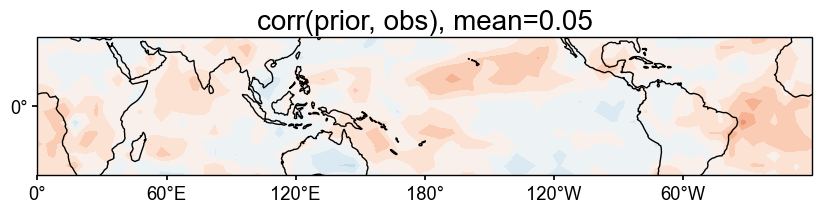

Figure saved at: "figs/pda_corr_prior_obs.pdf"


In [15]:
# validate the prior against HadCRUT
stat = 'corr'

valid_fd = job.prior['tas'].compare(
    target, stat=stat,
    timespan=(1874, 2000),
)

fig, ax = valid_fd.plot(
    title=f'{stat}(prior, obs), mean={valid_fd.geo_mean().value[0,0]:.2f}',
    projection='PlateCarree',
    latlon_range=(-32, 32, 0, 360),
    plot_cbar=False,
)

cfr.showfig(fig)
cfr.savefig(fig, f'./figs/pda_{stat}_prior_obs.pdf')

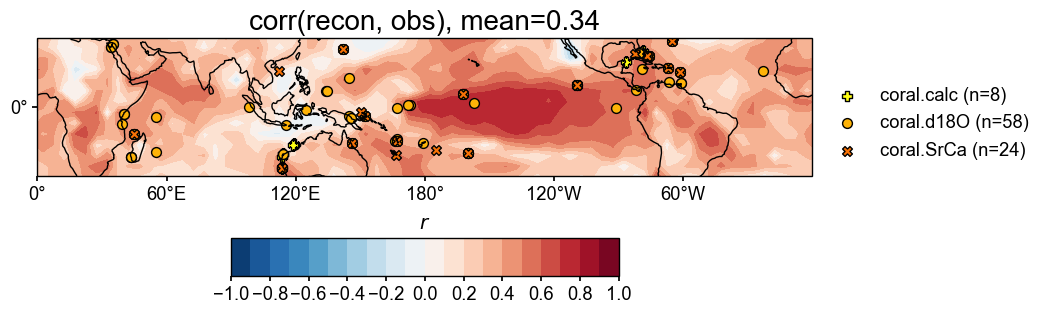

Figure saved at: "figs/pda_corr_recon_obs.pdf"


In [16]:
# validate the reconstruction against HadCRUT
valid_fd = res.recons['tas'].compare(
    target, stat=stat,
    timespan=(1874, 2000),
)
valid_fd.plot_kwargs.update({'cbar_orientation': 'horizontal', 'cbar_pad': 0.1})

fig, ax = valid_fd.plot(
    title=f'{stat}(recon, obs), mean={valid_fd.geo_mean().value[0,0]:.2f}',
    projection='PlateCarree',
    latlon_range=(-32, 32, 0, 360),
    plot_cbar=True, plot_proxydb=True, proxydb=job.proxydb.filter(by='tag', keys=['calibrated']),
    plot_proxydb_lgd=True, proxydb_lgd_kws={'loc': 'lower left', 'bbox_to_anchor': (1, 0)},
)

cfr.showfig(fig)
cfr.savefig(fig, f'./figs/pda_{stat}_recon_obs.pdf')

### Timeseries validation

In [17]:
bc09 = cfr.EnsTS().fetch('BC09_NINO34')
bc09_ann = bc09.annualize(months=[12, 1, 2])

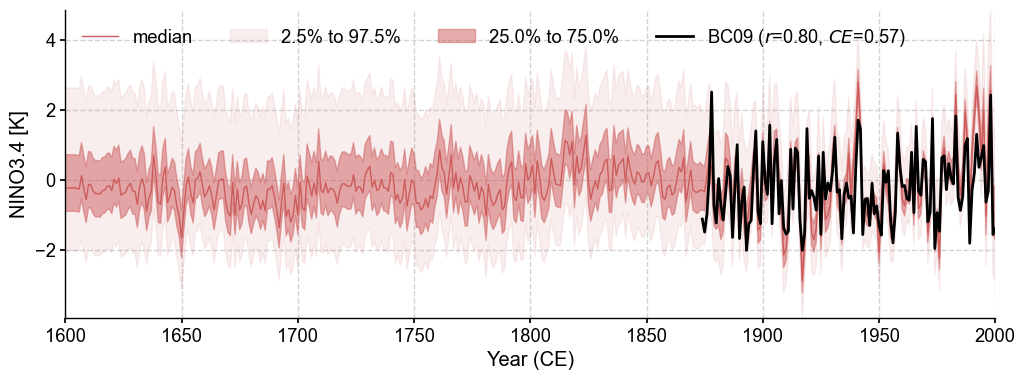

Figure saved at: "figs/pda_corr_recon_BC09.pdf"


In [19]:
fig, ax = res.recons['nino3.4'].compare(bc09_ann, timespan=(1874, 2000), ref_name='BC09').plot_qs()
ax.set_xlim(1600, 2000)
ax.set_ylabel('NINO3.4 [K]')
cfr.showfig(fig)
cfr.savefig(fig, f'./figs/pda_corr_recon_BC09.pdf')